## TODO:

 * better batching mechanism (maybe the prebuilt in TF)
 * try different optimizer (SGD with momentum, RMSProp) ?
 * learning rate decay ?
 * dropout, more layers, gradient clipping, bidirectional, ... ?
 * beam search

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
import nltk
import tensorflow as tf
import itertools

## Prepare vocabulary and a training set

I load the Sherlock holmes corpus and process it as follows:
 * All is converted to lowercase, all whitespace collapsed to a single space
 * nltk is used to tokenize into sentences and words. Special tokens START and END are added to the beginning and end of each sentence
 * Only the first 500 sentences are used for training (for simplicity and speed of learning)
 * All words are kept. Later we may drop all words frequent less than a threshold, or replace them with UNKNOWN token
 * Longer sentences are trimmed to length of 50 words, shorter sentences are padded (and masking is used in the training).

In [2]:
with open('../txa-hw/hw2/pg1661.txt', encoding='utf-8') as f:
    original_text = f.read()
# Strip meta info and table of contents at the beginning and licence at the end -> use only the book itself.
text = original_text[re.search('ADVENTURE I', original_text).start() : re.search('End of the Project Gutenberg EBook', original_text).start()]
text = text.lower().strip()
text = re.sub('\s+', ' ', text) # replace whitespaces with single space

In [3]:
sentences = nltk.sent_tokenize(text)

token_start = 'START'
token_end = 'END'
tok_sentences = [[token_start] + [w for w in nltk.word_tokenize(s) if w] + [token_end] for s in sentences]

train_size = 100  # limit training set to this number of first sentences
tok_sentences = tok_sentences[:train_size]

In [4]:
freq_dist = nltk.FreqDist(itertools.chain(*tok_sentences))

freq_threshold = 0
vocab = [(k,v) for k,v in freq_dist.items() if v >= freq_threshold]
vocab_size = len(vocab)
id_word = [v[0] for v in vocab]
word_id = {w:i for i,w in enumerate(id_word)}

# drop all words not in vocabulary (less frequent than freq_threshold)
# maybe to replace them with special token would be better?
# now we actually don't drop anything
tok_sentences = [[w for w in s if w in word_id] for s in tok_sentences]

max_len = 50

# cut all sentences to max_len
tok_sentences = [s[:max_len] for s in tok_sentences]

In [5]:
vocab_size

662

In [6]:
X = [[word_id[w] for w in s[:-1]] for s in tok_sentences]
Y = [[word_id[w] for w in s[1:]] for s in tok_sentences]  # shift-by-1 X, next-word prediction

X_lens = np.asarray([len(x) for x in X])
# Y_lens = [len(y) for y in Y]

# pad with zeros to max_len
X = np.asarray([np.pad(x, (0,max_len-len(x)), 'constant') for x in X])
Y = np.asarray([np.pad(y, (0,max_len-len(y)), 'constant') for y in Y])

## Build model and train

In [7]:
from lstm_language_model import RNNLanguageModel

# reload the module and reimport in case of change in code
import importlib
import lstm_language_model
importlib.reload(lstm_language_model)
from lstm_language_model import RNNLanguageModel

In [8]:
num_steps = max_len  # max. number of timesteps
embeding_size = 100
input_size = X.shape[0]
batch_size = 32
lstm_size = 100 # n_hidden and state_size?
learning_rate = 0.01
checkpoint_path = 'checkpoints/sherlock.ckp'

In [15]:
tf.reset_default_graph()
sess = tf.Session()
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

model = RNNLanguageModel(embedding_size=embeding_size, learning_rate=learning_rate, lstm_size=lstm_size, num_steps=num_steps, vocab_size=vocab_size, sess=sess, checkpoint_path=checkpoint_path)
model.build(model_type='train')

sess.run(tf.global_variables_initializer())

In [16]:
n_epochs = 20

model.train(X, Y, X_lens, n_epochs, batch_size, evaluate_every=5)

epoch 1
epoch 2
training loss after 5 steps: 4.62144517899 elapsed time: 00h 00m 01s
epoch 3
epoch 4
training loss after 10 steps: 3.47606348991 elapsed time: 00h 00m 02s
saved model to checkpoints/sherlock.ckp-10
epoch 5
training loss after 15 steps: 2.41555380821 elapsed time: 00h 00m 04s
epoch 6
epoch 7
training loss after 20 steps: 1.50818240643 elapsed time: 00h 00m 05s
saved model to checkpoints/sherlock.ckp-20
epoch 8
epoch 9
training loss after 25 steps: 0.845472693443 elapsed time: 00h 00m 08s
epoch 10
training loss after 30 steps: 0.496541559696 elapsed time: 00h 00m 09s
saved model to checkpoints/sherlock.ckp-30
epoch 11
epoch 12
training loss after 35 steps: 0.364254385233 elapsed time: 00h 00m 11s
epoch 13
epoch 14
training loss after 40 steps: 0.309825122356 elapsed time: 00h 00m 12s
saved model to checkpoints/sherlock.ckp-40
epoch 15
training loss after 45 steps: 0.282669723034 elapsed time: 00h 00m 15s
epoch 16
epoch 17
training loss after 50 steps: 0.273558914661 elaps

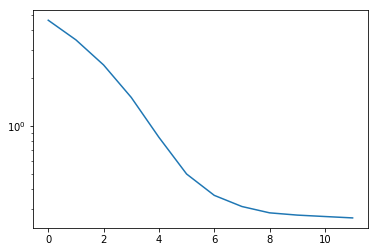

In [17]:
plt.semilogy(model.losses)

In [18]:
sess.close()

## Generate text

In [19]:
tf.reset_default_graph()
sess = tf.Session()
model.sess = sess
model.build(model_type='infer')
model.saver.restore(sess, checkpoint_path + '-final')

INFO:tensorflow:Restoring parameters from checkpoints/sherlock.ckp-final


In [20]:
seq = ['START']
seq = [word_id[s] for s in seq]
state = init_state = np.zeros((2, 1, lstm_size))

num_words = 500

for i in range(len(seq)-1, num_words):
    p, state = model.infer(np.reshape(seq[-1], (1,1)), np.array([1]), state)
#     max_id = np.argmax(p)
    p = p.reshape([-1])
    max_id = np.random.choice(list(range(len(p))), p=p)
    seq.append(max_id)
    print(id_word[max_id], end=' ')
    if max_id == word_id[token_end]: # restart the sentence
        print()
        seq.append(word_id[token_start])
        state = init_state

this account of you we have from all quarters received . END 
`` 'eg i had seen little of holmes lately . END 
and yet i believe that my eyes are as good as yours . '' END 
`` seven ! '' END 
i carefully examined the writing , and the paper upon which it written . END 
`` the name of the maker , no doubt ; or his monogram , rather . '' END 
with hardly a word spoken , but with a kindly eye , he waved me to an armchair , threw across his case of cigars , and indicated a spirit case and a gasogene in the corner . END 
but the note itself . END 
`` i see it , i deduce it , and . END 
the distinction is clear . END 
i did so , and saw a large `` e '' with a small `` g , '' a `` p , '' and a large `` g '' with a small `` t '' woven into the texture of the paper . END 
for example , you have frequently seen the steps which lead up from the hall to this room . '' END 
adventure i. a scandal in bohemia i. to sherlock holmes she is always the woman . END 
`` what do you imagine that it means ? 